In [1]:
!pip install tqdm

In [1]:
from tqdm import tqdm
import os
import numpy as np
import pandas as pd
from scapy.all import rdpcap, IP, TCP, UDP
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split

In [18]:
from scapy.all import rdpcap, wrpcap, IP, TCP, UDP

In [1]:
import pandas as pd
from scapy.all import rdpcap, wrpcap, IP, TCP, UDP
from tqdm import tqdm
from collections import defaultdict

# === Load and preprocess ground truth ===
gt = pd.read_csv(r"C:\Users\ulami\Desktop\NUSW-NB15_GT_22_01.csv")

gt["key"] = list(zip(
    gt["Source IP"],
    gt["Destination IP"],
    gt["Source Port"].astype(int),
    gt["Destination Port"].astype(int),
    gt["Protocol"].str.lower()
))

gt_index = defaultdict(list)
for _, row in gt.iterrows():
    gt_index[row["key"]].append((row["Start time"], row["Last time"]))


# === Labeling function ===
def get_attack_label(timestamp, src_ip, dst_ip, sport, dport, proto):
    candidates = gt[
        (gt["Start time"] <= timestamp) &
        (gt["Last time"] >= timestamp) &
        (gt["Source IP"] == src_ip) &
        (gt["Destination IP"] == dst_ip) &
        (gt["Source Port"].astype(int) == sport) &
        (gt["Destination Port"].astype(int) == dport) &
        (gt["Protocol"].str.lower() == proto.lower())
    ]
    return 1 if not candidates.empty else 0


# === Load packets and classify ===
packets = rdpcap(r"C:\Users\ulami\Desktop\datasety\UNSW-NB15-pcap\3.pcap")

attack_packets = []
normal_packets = []

matched, unmatched, skipped = 0, 0, 0

for pkt in tqdm(packets, desc="Classifying packets"):
    try:
        if IP in pkt and (TCP in pkt or UDP in pkt):
            proto = "tcp" if TCP in pkt else "udp"
            l4 = pkt[TCP] if TCP in pkt else pkt[UDP]
            src_ip = pkt[IP].src
            dst_ip = pkt[IP].dst
            sport = l4.sport
            dport = l4.dport
            timestamp = int(pkt.time)

            label = get_attack_label(timestamp, src_ip, dst_ip, sport, dport, proto)
            if label == 1:
                matched += 1
                attack_packets.append(pkt)
            else:
                unmatched += 1
                normal_packets.append(pkt)
    except Exception as e:
        skipped += 1

print(f"Matched (attack): {matched}")
print(f"Unmatched (normal): {unmatched}")
print(f"Skipped: {skipped}")
print(f"Total read: {len(packets)}")


# === Save to PCAP files ===
wrpcap(r"C:\Users\ulami\Desktop\datasety\UNSW-NB15-pcap\attack3.pcap", attack_packets)
wrpcap(r"C:\Users\ulami\Desktop\datasety\UNSW-NB15-pcap\normal3.pcap", normal_packets)


Classifying packets: 100%|██████████| 1752554/1752554 [1:43:19<00:00, 282.67it/s]


Matched (attack): 16793
Unmatched (normal): 1735244
Skipped: 0
Total read: 1752554


In [5]:
print(f"Matched (attack): {matched}")
print(f"Unmatched (normal): {unmatched}")
print(f"Skipped: {skipped}")
print(f"Total read: {len(packets)}")

Matched (attack): 980
Unmatched (normal): 153546
Skipped: 0
Total read: 1800680


# MODEL

In [3]:
from scapy.all import rdpcap, IP, Ether, CookedLinux
import os
import numpy as np

def remove_ip(packet):
    # Neutralize MAC addresses
    if Ether in packet:
        packet[Ether].src = "00:00:00:00:00:00"
        packet[Ether].dst = "00:00:00:00:00:00"
    elif CookedLinux in packet:
        packet[CookedLinux].src = "00:00:00:00:00:00"
        
    if IP in packet:
        packet[IP].src = '0.0.0.0'
        packet[IP].dst = '0.0.0.0'
        del packet[IP].chksum

        # Clear transport-layer checksums
        if packet.haslayer("TCP"):
            del packet["TCP"].chksum
        elif packet.haslayer("UDP"):
            del packet["UDP"].chksum
    return packet

def packet_to_bytes(pkt, max_len):
    pkt = remove_ip(pkt)
    raw = bytes(pkt)
    if len(raw) > max_len:
        return raw[:max_len]
    else:
        return raw.ljust(max_len, b'\x00')  # pad with zeros

def extract_raw_bytes_from_folder(folder_path, max_len=100):
    all_features = []
    for file in os.listdir(folder_path):
        if file.lower().endswith('.pcap'):
            file_path = os.path.join(folder_path, file)
            print(f"Processing {file_path}")
            packets = rdpcap(file_path)
            features = [packet_to_bytes(pkt, max_len) for pkt in packets]
            all_features.extend(features)
    # Convert to numpy array
    return np.array([np.frombuffer(x, dtype=np.uint8) for x in all_features])

In [4]:
from sklearn.model_selection import train_test_split

normal_folder = r"C:\Users\ulami\Desktop\datasety\UNSW-NB15-pcap\normal"
attack_folder = r"C:\Users\ulami\Desktop\datasety\UNSW-NB15-pcap\attack"

# Extract and label
X_normal = extract_raw_bytes_from_folder(normal_folder)
X_attack = extract_raw_bytes_from_folder(attack_folder)

y_normal = np.zeros(X_normal.shape[0])
y_attack = np.ones(X_attack.shape[0])

# Combine data and labels
X = np.vstack((X_normal, X_attack))
y = np.hstack((y_normal, y_attack))

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Reshape for CNN input
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

Processing C:\Users\ulami\Desktop\datasety\UNSW-NB15-pcap\normal\normal.pcap


Processing C:\Users\ulami\Desktop\datasety\UNSW-NB15-pcap\attack\attack.pcap


Processing C:\Users\ulami\Desktop\datasety\UNSW-NB15-pcap\attack\attack2.pcap
Processing C:\Users\ulami\Desktop\datasety\UNSW-NB15-pcap\attack\attack3.pcap


In [5]:
# Combine for full dataset
X_all = np.vstack((X_normal, X_attack))
y_all = np.hstack((y_normal, y_attack))

# Normalize data before splitting
X_all = X_all.astype(np.float32) / 255.0

attack_start_idx = len(X_normal)
all_indices = np.arange(len(X_all))

# Split dataset
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X_all, y_all, all_indices, test_size=0.2, random_state=42, stratify=y_all
)

# CNN reshape
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [6]:
from tensorflow.keras.models import load_model
model = load_model(r"C:\Users\ulami\Desktop\magisterka\models_final\unsw_pcap_final.keras")

In [7]:
from tensorflow.keras.models import load_model
final_model = load_model(r"C:\Users\ulami\Desktop\magisterka\models_final\UNSW_NB15_csv_final.keras")   

In [9]:
final_model.summary()

Model: "sequential_162"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_575 (Dense)               │ (None, 32)             │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_576 (Dense)               │ (None, 4)              │           132 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_577 (Dense)               │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,237 (8.74 KB)

 Trainable params: 745 (2.91 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,492 (5.83 KB)

In [30]:
input_dim

100

In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, Dense
from tensorflow.keras.optimizers import Adam

def build_model(input_dim: int):
    m = Sequential()
    n_channels = 1
    m.add(Input(shape=(input_dim, n_channels)))

    for i in range(best_params['n_layers']):
        filters = best_params.get(f"n_units_l{i}")            # use your existing units as conv filters
        ksize   = 5
        dr      = best_params.get(f"dropout_l{i}", 0.0)
        poolsz  = best_params.get(f"pool_size_l{i}")          # set >1 to enable per-layer pooling

        m.add(Conv1D(filters=filters, kernel_size=ksize,
                     activation='relu', padding='same'))
        if poolsz and poolsz > 1:
            m.add(MaxPooling1D(pool_size=poolsz))
        if dr and dr > 0:
            m.add(Dropout(dr))

    m.add(GlobalMaxPooling1D())
    m.add(Dense(32, activation='relu'))
    m.add(Dense(1, activation='sigmoid'))

    m.compile(optimizer=Adam(learning_rate=best_params['learning_rate']),
              loss='binary_crossentropy',
              metrics=['accuracy'])
    return m


In [58]:
# ----- Your fixed best hyperparameters -----
best_params = {
    'epochs': 5,
    'n_layers': 3,
    'n_units_l0': 64, 'dropout_l0': 0.0,
    'n_units_l1': 4, 'dropout_l1': 0.0,
    'n_units_l2': 8, 'dropout_l2': 0.0,
    'learning_rate': 1e-3,
    'batch_size': 32
}

In [65]:
model = build_model(input_dim=X_train.shape[1])

In [66]:
model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_37 (Conv1D)              │ (None, 100, 64)        │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_38 (Conv1D)              │ (None, 100, 4)         │         1,284 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_39 (Conv1D)              │ (None, 100, 8)         │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_11         │ (None, 8)              │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 32)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,157 (8.43 KB)

 Trainable params: 2,157 (8.43 KB)

 Non-trainable params: 0 (0.00 B)

In [71]:
model = build_model(input_dim=X_train.shape[1])
model.fit(
    X_train, y_train,
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    validation_split=0.2,
    verbose=1
)

test_preds = (model.predict(X_test, verbose=1).ravel() > 0.5).astype(int)

Epoch 1/5
37405/37405 ━━━━━━━━━━━━━━━━━━━━ 167s 4ms/step - accuracy: 0.9816 - loss: 0.0524 - val_accuracy: 0.9916 - val_loss: 0.0209
Epoch 2/5
37405/37405 ━━━━━━━━━━━━━━━━━━━━ 166s 4ms/step - accuracy: 0.9921 - loss: 0.0188 - val_accuracy: 0.9931 - val_loss: 0.0157
Epoch 3/5
37405/37405 ━━━━━━━━━━━━━━━━━━━━ 164s 4ms/step - accuracy: 0.9935 - loss: 0.0149 - val_accuracy: 0.9927 - val_loss: 0.0163
Epoch 4/5
37405/37405 ━━━━━━━━━━━━━━━━━━━━ 163s 4ms/step - accuracy: 0.9937 - loss: 0.0145 - val_accuracy: 0.9935 - val_loss: 0.0142
Epoch 5/5
37405/37405 ━━━━━━━━━━━━━━━━━━━━ 161s 4ms/step - accuracy: 0.9940 - loss: 0.0138 - val_accuracy: 0.9944 - val_loss: 0.0129
11690/11690 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step


In [73]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

accuracy = accuracy_score(y_test, test_preds)
precision = precision_score(y_test, test_preds)
recall = recall_score(y_test, test_preds)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

Accuracy: 0.99
Precision: 0.93
Recall: 0.97


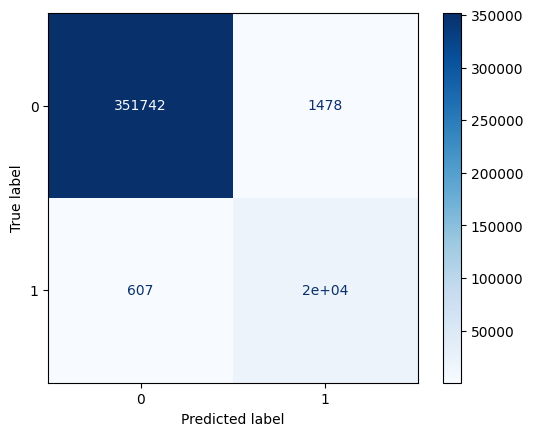

                precision    recall  f1-score   support

Normal Traffic       1.00      1.00      1.00    353220
        Attack       0.93      0.97      0.95     20830

      accuracy                           0.99    374050
     macro avg       0.97      0.98      0.97    374050
  weighted avg       0.99      0.99      0.99    374050



In [74]:
from sklearn.metrics import classification_report

cm = confusion_matrix(y_test, test_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

# Print detailed classification report
print(classification_report(y_test, test_preds, target_names=['Normal Traffic', 'Attack']))

In [16]:
# Original full packets for those test attack samples
attack_test_mask = y_test == 1
X_attack_test = X_test[attack_test_mask].squeeze(axis=-1)
y_attack_test = y_test[attack_test_mask]
idx_attack_test = idx_test[attack_test_mask]

# Map test indices back to attack-only packets
# All attack packets are offset by len(X_normal)
relative_attack_indices = idx_attack_test - attack_start_idx
packets_attack_test = [packets_attack[i] for i in relative_attack_indices]

In [76]:
# Save the trained model
model.save("unsw_pcap_final.keras")

# Integrated gradient

In [179]:
def compute_integrated_gradients(model, input_tensor, baseline=None, steps=50):
    if baseline is None:
        baseline = tf.zeros(shape=input_tensor.shape)

    interpolated_inputs = [
        baseline + (float(i) / steps) * (input_tensor - baseline)
        for i in range(steps + 1)
    ]

    grads = []
    for inp in interpolated_inputs:
        with tf.GradientTape() as tape:
            tape.watch(inp)
            pred = model(inp)
        grad = tape.gradient(pred, inp)
        grads.append(grad.numpy())

    avg_grads = np.average(grads[:-1], axis=0)
    integrated_grads = (input_tensor.numpy() - baseline.numpy()) * avg_grads
    return integrated_grads.squeeze()

def compute_ig_for_samples(model, X_subset, steps=50, max_samples=100, baseline=None):
    attributions_list = []
    for i in range(min(len(X_subset), max_samples)):
        input_sample = tf.convert_to_tensor([X_subset[i]], dtype=tf.float32)
        ig = compute_integrated_gradients(model, input_sample, baseline=baseline, steps=steps)
        attributions_list.append(ig)
    return np.array(attributions_list)

# Separate test samples
X_normal_test = X_test[y_test == 0]
X_attack_test = X_test[y_test == 1]


In [180]:
a_normal_min = X_normal_test.shape[0] *0.01
a_normal_max = X_normal_test.shape[0] *0.05

a_attack_min = X_attack_test.shape[0] *0.01
a_attack_max = X_attack_test.shape[0] *0.05

a_normal_min, a_normal_max, a_attack_min, a_attack_max

(3532.2000000000003, 17661.0, 208.3, 1041.5)

In [49]:
import pandas as pd

# Compute IG
normal_attributions = compute_ig_for_samples(model, X_normal_test, max_samples=17000)
attack_attributions = compute_ig_for_samples(model, X_attack_test, max_samples=1000)
# overall_attributions = compute_ig_for_samples(model, X_test, max_samples=500)

# Average IG
avg_normal_ig = np.mean(normal_attributions, axis=0)
avg_attack_ig = np.mean(attack_attributions, axis=0)
# avg_all_ig = np.mean(overall_attributions, axis=0)


In [50]:
# Normal
df_normal = pd.DataFrame({
    "Byte Index": np.arange(len(avg_normal_ig)),
    "Attribution (Normal Class)": avg_normal_ig
})
df_normal["Abs Attribution"] = np.abs(df_normal["Attribution (Normal Class)"])
df_normal_sorted = df_normal.sort_values("Abs Attribution", ascending=False)

# Attack
df_attack = pd.DataFrame({
    "Byte Index": np.arange(len(avg_attack_ig)),
    "Attribution (Attack Class)": avg_attack_ig
})
df_attack["Abs Attribution"] = np.abs(df_attack["Attribution (Attack Class)"])
df_attack_sorted = df_attack.sort_values("Abs Attribution", ascending=False)

# Display top 20
df_normal_sorted.head(20), df_attack_sorted.head(20)

(    Byte Index  Attribution (Normal Class)  Abs Attribution
 24          24                    0.013691         0.013691
 51          51                    0.011488         0.011488
 53          53                    0.010813         0.010813
 62          62                   -0.007306         0.007306
 52          52                    0.007158         0.007158
 38          38                   -0.006379         0.006379
 60          60                   -0.006258         0.006258
 12          12                    0.006193         0.006193
 20          20                   -0.006141         0.006141
 50          50                   -0.005840         0.005840
 36          36                    0.005646         0.005646
 39          39                   -0.005036         0.005036
 61          61                   -0.004635         0.004635
 9            9                    0.004256         0.004256
 49          49                   -0.003803         0.003803
 37          37         

In [51]:
# All
df_all = pd.DataFrame({
    "Byte Index": np.arange(len(avg_all_ig)),
    "Attribution": avg_all_ig
})
df_all["Abs Attribution"] = np.abs(df_all["Attribution"])
df_all_sorted = df_all.sort_values("Abs Attribution", ascending=False)

df_all_sorted.head(20)

,Byte Index,Attribution,Abs Attribution
24,24,0.031931,0.031931
51,51,0.031114,0.031114
26,26,-0.018980,0.018980
36,36,0.010261,0.010261
62,62,-0.007619,0.007619
53,53,0.007488,0.007488
16,16,0.007322,0.007322
48,48,-0.007292,0.007292
21,21,0.006664,0.006664
66,66,-0.006471,0.006471


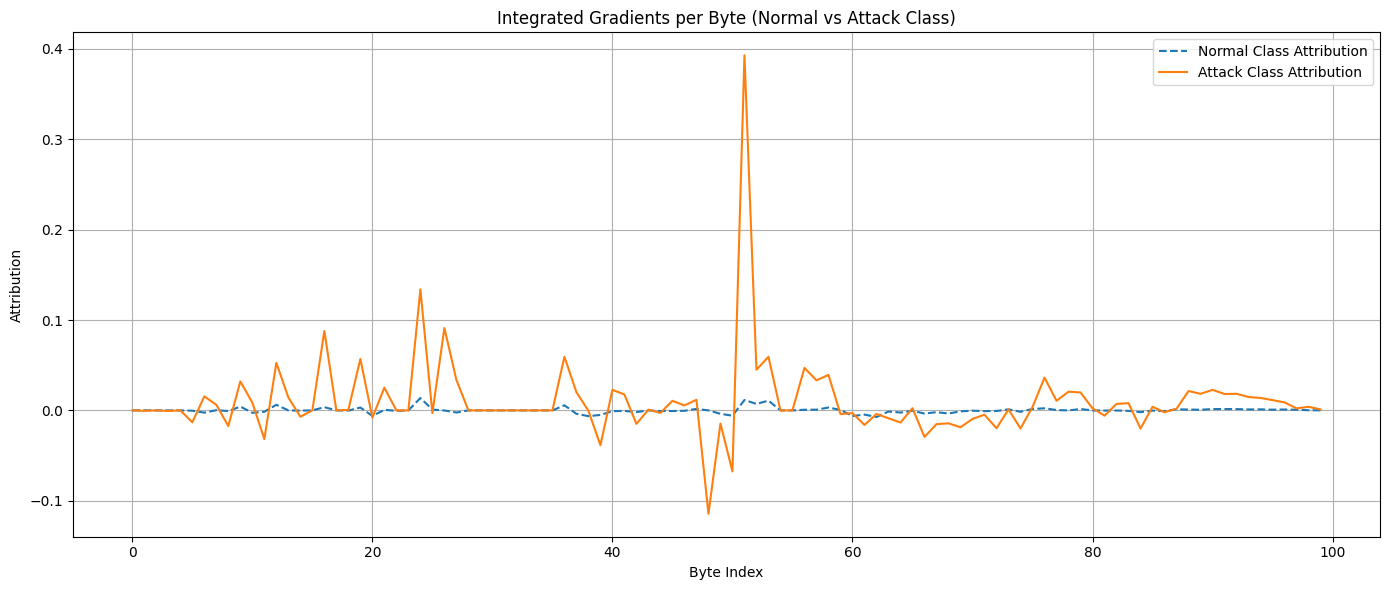

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(avg_normal_ig, label="Normal Class Attribution", linestyle='--')
plt.plot(avg_attack_ig, label="Attack Class Attribution", linestyle='-')
plt.title("Integrated Gradients per Byte (Normal vs Attack Class)")
plt.xlabel("Byte Index")
plt.ylabel("Attribution")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Top values attack:
*  bytes 50-51 - TCP widow size  ✅
*  bytes 52-53 - TCP checksum
*  byte 24 - IP TTL   ✅
*  byte 48 - TCP NS flag (Nonce)   ✅
*  byte 16 - IP header length
*  bytes 26-27 - IP checksum

## Baseline - mean

In [64]:
# mean of normal test samples as a baseline
normal_mean = np.mean(X_normal_test, axis=0)
baseline_tensor = tf.convert_to_tensor([normal_mean], dtype=tf.float32)

normal_attributions = compute_ig_for_samples(model, X_normal_test, max_samples=3000, baseline=baseline_tensor)
attack_attributions = compute_ig_for_samples(model, X_attack_test, max_samples=1000, baseline=baseline_tensor)


In [65]:
# Average IG
avg_normal_mean_ig = np.mean(normal_attributions, axis=0)
avg_attack_mean_ig = np.mean(attack_attributions, axis=0)

In [66]:
# Normal
df_normal_mean = pd.DataFrame({
    "Byte Index": np.arange(len(avg_normal_mean_ig)),
    "Attribution (Normal Class)": avg_normal_mean_ig
})
df_normal_mean["Abs Attribution"] = np.abs(df_normal_mean["Attribution (Normal Class)"])
df_normal_mean_sorted = df_normal_mean.sort_values("Abs Attribution", ascending=False)

# Attack
df_attack_mean = pd.DataFrame({
    "Byte Index": np.arange(len(avg_attack_mean_ig)),
    "Attribution (Attack Class)": avg_attack_mean_ig
})
df_attack_mean["Abs Attribution"] = np.abs(df_attack_mean["Attribution (Attack Class)"])
df_attack_mean_sorted = df_attack_mean.sort_values("Abs Attribution", ascending=False)

# Display top 20
df_normal_mean_sorted.head(20), df_attack_mean_sorted.head(20)

(    Byte Index  Attribution (Normal Class)  Abs Attribution
 36          36                   -0.021732         0.021732
 24          24                    0.011668         0.011668
 22          22                    0.007066         0.007066
 26          26                    0.002518         0.002518
 60          60                   -0.001768         0.001768
 61          61                    0.001588         0.001588
 51          51                    0.001452         0.001452
 57          57                    0.001424         0.001424
 67          67                    0.001088         0.001088
 58          58                    0.001079         0.001079
 69          69                   -0.000889         0.000889
 19          19                    0.000647         0.000647
 62          62                    0.000626         0.000626
 43          43                    0.000507         0.000507
 40          40                    0.000462         0.000462
 38          38         

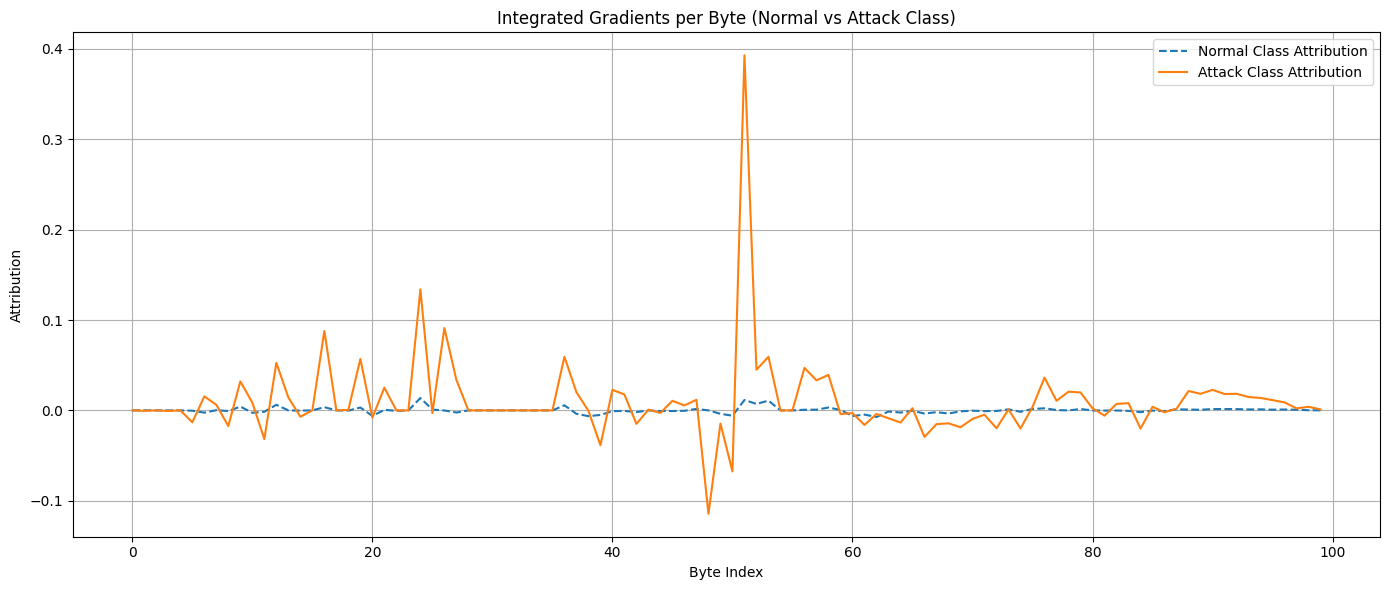

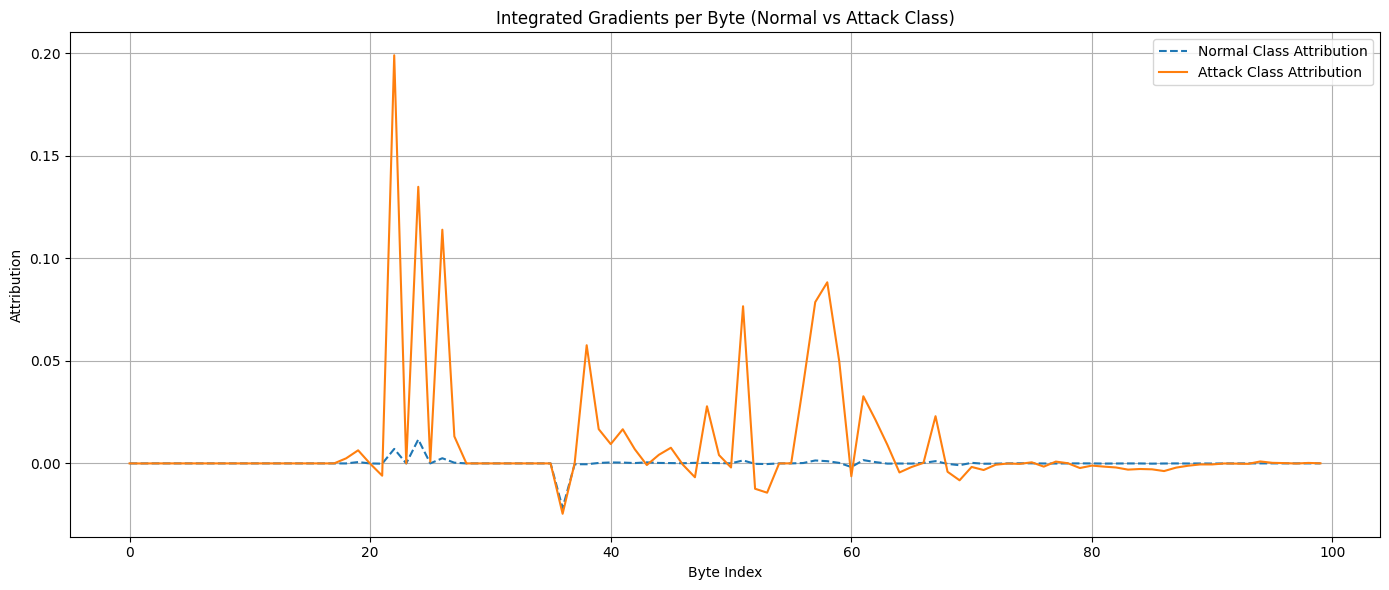

In [67]:
import matplotlib.pyplot as plt
# baseline [0..0]
plt.figure(figsize=(14, 6))
plt.plot(avg_normal_ig, label="Normal Class Attribution", linestyle='--')
plt.plot(avg_attack_ig, label="Attack Class Attribution", linestyle='-')
plt.title("Integrated Gradients per Byte (Normal vs Attack Class)")
plt.xlabel("Byte Index")
plt.ylabel("Attribution")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# baseline mean
plt.figure(figsize=(14, 6))
plt.plot(avg_normal_mean_ig, label="Normal Class Attribution", linestyle='--')
plt.plot(avg_attack_mean_ig, label="Attack Class Attribution", linestyle='-')
plt.title("Integrated Gradients per Byte (Normal vs Attack Class)")
plt.xlabel("Byte Index")
plt.ylabel("Attribution")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# FGSM

In [7]:
X_test_normal = X_test[y_test == 0]
y_test_normal = y_test[y_test == 0]

X_test_attack = X_test[y_test == 1]
y_test_attack = y_test[y_test == 1]

In [199]:
def fgsm_attack(model, x, y_true, epsilon=0.01):
    x_adv = tf.convert_to_tensor(x, dtype=tf.float32)
    y_true = tf.convert_to_tensor(y_true, dtype=tf.float32)
    y_true = tf.reshape(y_true, (-1, 1))

    with tf.GradientTape() as tape:
        tape.watch(x_adv)
        prediction = model(x_adv)
        loss = tf.keras.losses.binary_crossentropy(y_true, prediction)

    # Compute gradients
    gradient = tape.gradient(loss, x_adv)
    signed_grad = tf.sign(gradient)

    # Apply perturbation
    x_adv = x_adv + epsilon * signed_grad
    x_adv = tf.clip_by_value(x_adv, 0.0, 1.0)

    return x_adv


In [200]:
# Generate adversarial samples
X_test_attack_adv = fgsm_attack(model, X_attack_test, y_attack_test, epsilon=0.2)


In [10]:
def patch_full_packet_bytes(pkt, fgsm_bytes):
    raw = bytearray(bytes(pkt))
    fgsm_bytes = bytes(fgsm_bytes)

    # Replace first N bytes with FGSM output
    raw[:len(fgsm_bytes)] = fgsm_bytes

    try:
        new_pkt = Ether(bytes(raw))
        return fix_checksums(new_pkt)
    except:
        return None

def save_fgsm_patched_full_packets(original_packets, x_adv_uint8, output_path):
    patched = []
    for orig_pkt, adv_bytes in zip(original_packets, x_adv_uint8):
        pkt = patch_full_packet_bytes(orig_pkt, adv_bytes)
        if pkt:
            patched.append(pkt)
    wrpcap(output_path, patched)
    print(f"✅ Saved {len(patched)} full FGSM-modified packets to {output_path}")


In [204]:
# x_adv_normalized: output of fgsm_attack (normalized)
x_adv_uint8 = (X_test_attack_adv.numpy() * 255).astype(np.uint8)

save_fgsm_patched_full_packets(packets_attack_test, x_adv_uint8, "fgsm_full_modified_attack.pcap")


✅ Saved 20830 full FGSM-modified packets to fgsm_full_modified_attack.pcap


In [205]:
X_test = np.vstack((X_test_normal, X_test_attack_adv))
y_test = np.hstack((y_test_normal, y_attack_test))

In [206]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Get predictions
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

11690/11690 ━━━━━━━━━━━━━━━━━━━━ 10s 855us/step
Accuracy: 0.94
Precision: 0.44
Recall: 0.06


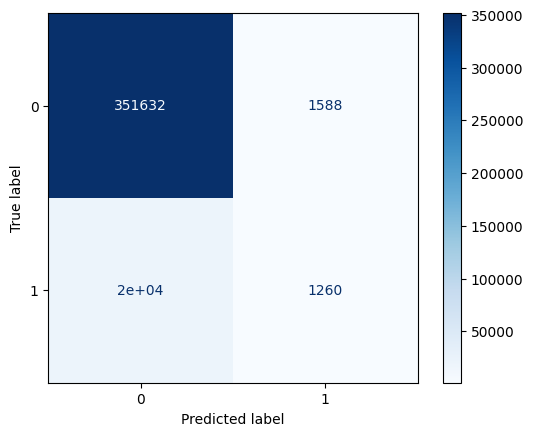

                precision    recall  f1-score   support

Normal Traffic       0.95      1.00      0.97    353220
        Attack       0.44      0.06      0.11     20830

      accuracy                           0.94    374050
     macro avg       0.69      0.53      0.54    374050
  weighted avg       0.92      0.94      0.92    374050



In [207]:
from sklearn.metrics import classification_report

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

# Print detailed classification report
print(classification_report(y_test, y_pred, target_names=['Normal Traffic', 'Attack']))

### Mniejszy epsilon

In [208]:
# Generate adversarial samples
X_test_attack_adv = fgsm_attack(model, X_attack_test, y_attack_test, epsilon=0.05)


In [209]:
# x_adv_normalized: output of fgsm_attack (normalized)
x_adv_uint8 = (X_test_attack_adv.numpy() * 255).astype(np.uint8)

save_fgsm_patched_full_packets(packets_attack_test, x_adv_uint8, "fgsm_full_modified_small_attack.pcap")


✅ Saved 20830 full FGSM-modified packets to fgsm_full_modified_small_attack.pcap


In [210]:
X_test = np.vstack((X_test_normal, X_test_attack_adv))
y_test = np.hstack((y_test_normal, y_attack_test))

In [211]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Get predictions
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

11690/11690 ━━━━━━━━━━━━━━━━━━━━ 10s 846us/step
Accuracy: 0.98
Precision: 0.90
Recall: 0.71


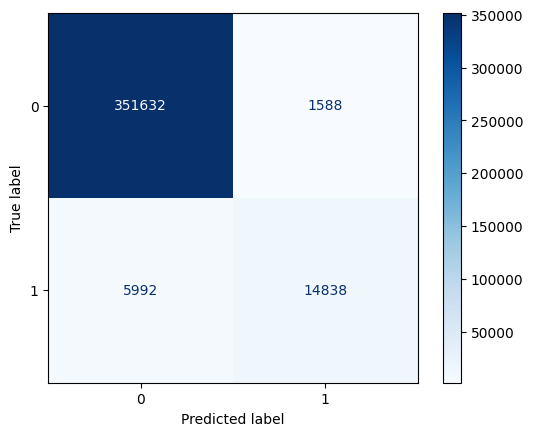

                precision    recall  f1-score   support

Normal Traffic       0.98      1.00      0.99    353220
        Attack       0.90      0.71      0.80     20830

      accuracy                           0.98    374050
     macro avg       0.94      0.85      0.89    374050
  weighted avg       0.98      0.98      0.98    374050



In [212]:
from sklearn.metrics import classification_report

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

# Print detailed classification report
print(classification_report(y_test, y_pred, target_names=['Normal Traffic', 'Attack']))

# FGSM - targeted byte positions only

In [184]:
import numpy as np
import tensorflow as tf

def fgsm_attack_on_target_fields(model, x, y_true, epsilon=0.01, target_indices=[24, 48, 50, 51]):
    """
      - index 24 (ip.ttl): integer in [0,255]
      - index 48 (tcp.flags.ns): integer in {0,1}
      - indices 50-51 (tcp.window_size_value): 16-bit integer in [1,65535] stored as two bytes (big-endian)
    """
    # Ensure numpy array and float32 scaled in [0,1]
    x_np = np.array(x, dtype=np.float32)
    if x_np.max() > 1.0 or x_np.min() < 0.0:
        raise ValueError("Input x appears not to be scaled to [0,1]. Provide x scaled by /255.0.")

    batch_size, n_features = x_np.shape

    # prepare tensors for gradient computation (already in 0..1)
    x_tensor = tf.convert_to_tensor(x_np, dtype=tf.float32)
    y_tensor = tf.convert_to_tensor(y_true, dtype=tf.float32)
    y_tensor = tf.reshape(y_tensor, (-1, 1))

    with tf.GradientTape() as tape:
        tape.watch(x_tensor)
        prediction = model(x_tensor)
        loss = tf.keras.losses.binary_crossentropy(y_tensor, prediction)
        loss = tf.reduce_mean(loss)

    gradient = tape.gradient(loss, x_tensor)
    signed_grad = tf.sign(gradient)

    # Build mask (batch, features) with 1.0 only at target indices
    mask = np.zeros((batch_size, n_features), dtype=np.float32)
    for idx in target_indices:
        if 0 <= idx < n_features:
            mask[:, idx] = 1.0
    mask_tf = tf.convert_to_tensor(mask, dtype=tf.float32)

    # Apply FGSM step in scaled space and clip to [0,1]
    x_adv_tensor = x_tensor + epsilon * signed_grad * mask_tf
    x_adv_tensor = tf.clip_by_value(x_adv_tensor, 0.0, 1.0)
    x_adv_scaled = x_adv_tensor.numpy().astype(np.float32)  # still scaled [0,1]

    # --- Now enforce constraints on UN-SCALED integer bytes ---
    # Convert scaled values to integer bytes (0..255)
    x_unscaled = np.rint(x_adv_scaled * 255.0).astype(np.int32)  # shape (batch, features), ints in 0..255

    # 1) ip.ttl at index 24: clamp to [0,255]
    idx_ttl = 24
    if idx_ttl < n_features:
        x_unscaled[:, idx_ttl] = np.clip(x_unscaled[:, idx_ttl], 0, 255)

    # 2) tcp.flags.ns at index 48: enforce {0,1}
    idx_ns = 48
    if idx_ns < n_features:
        # Round to nearest integer 0 or 1 (we assume the unscaled representation is 0 or 1)
        ns_vals = np.rint(x_unscaled[:, idx_ns]).astype(np.int32)
        ns_vals = np.clip(ns_vals, 0, 1)
        x_unscaled[:, idx_ns] = ns_vals

    # 3) tcp.window_size_value across indices 50 (hi) and 51 (lo): enforce [1,65535] (big-endian)
    idx_win_hi = 50
    idx_win_lo = 51
    if idx_win_hi < n_features and idx_win_lo < n_features:
        hi = np.rint(x_unscaled[:, idx_win_hi]).astype(np.int32) & 0xFF
        lo = np.rint(x_unscaled[:, idx_win_lo]).astype(np.int32) & 0xFF
        combined = (hi << 8) + lo  # big-endian: hi*256 + lo

        # enforce inclusive range [1,65535]
        combined = np.clip(combined, 1, 65535).astype(np.int32)

        # split back into two bytes (big-endian)
        hi_new = (combined >> 8) & 0xFF
        lo_new = combined & 0xFF
        x_unscaled[:, idx_win_hi] = hi_new
        x_unscaled[:, idx_win_lo] = lo_new

    # Ensure all bytes remain in 0..255 after modifications
    x_unscaled = np.clip(x_unscaled, 0, 255).astype(np.int32)

    # Convert back to scaled floats [0,1], dtype float32
    x_final_scaled = (x_unscaled.astype(np.float32) / 255.0).astype(np.float32)

    return x_final_scaled


In [23]:
### ---------- FGSM Patch into Packets ---------- ###
def patch_packet_with_fgsm_bytes(pkt, fgsm_bytes):
    try:
        if IP in pkt:
            pkt[IP].ttl = int(fgsm_bytes[24])
            del pkt[IP].chksum

        if TCP in pkt:
            ns_flag = int(fgsm_bytes[48]) & 1
            pkt[TCP].flags |= (ns_flag << 8)
            win_size = int(fgsm_bytes[50]) << 8 | int(fgsm_bytes[51])
            pkt[TCP].window = win_size
            del pkt[TCP].chksum

        return pkt
    except Exception as e:
        print(f"⚠️ Packet modification error: {e}")
        return None

In [24]:
def save_fgsm_modified_packets(original_packets, fgsm_bytes_array, output_path):
    patched_packets = []
    for pkt, fgsm_bytes in zip(original_packets, fgsm_bytes_array):
        patched = patch_packet_with_fgsm_bytes(pkt.copy(), fgsm_bytes)
        if patched:
            patched_packets.append(patched)

    if patched_packets:
        wrpcap(output_path, patched_packets)
        print(f"✅ Saved {len(patched_packets)} FGSM-modified packets to: {output_path}")
    else:
        print("⚠️ No valid packets to save.")

In [189]:
# FGSM attack on selected bytes
x_adv_normalized = fgsm_attack_on_target_fields(model, X_attack_test, y_attack_test, epsilon=0.2)

In [190]:
# Denormalize from [0, 1] back to [0, 255] and convert to uint8
x_adv_uint8 = (x_adv_normalized * 255).astype(np.uint8)

# Inject modified fields into packets and save
save_fgsm_modified_packets(packets_attack_test, X_test_attack_adv_targeted_bytes, "fgsm_modified_attack.pcap")

C:\Users\ulami\AppData\Local\Temp\ipykernel_26960\1371682187.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pkt[IP].ttl = int(fgsm_bytes[24])
C:\Users\ulami\AppData\Local\Temp\ipykernel_26960\1371682187.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ns_flag = int(fgsm_bytes[48]) & 1
C:\Users\ulami\AppData\Local\Temp\ipykernel_26960\1371682187.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  win_size = int(fgsm_bytes[50]) << 8 | int(fgsm_bytes[51])


✅ Saved 20830 FGSM-modified packets to: fgsm_modified_attack.pcap


In [195]:
normal_test_mask = y_test == 0
X_test_normal = X_test[normal_test_mask]
y_test_normal = y_test[normal_test_mask]  # should be all 0s


In [196]:
# x_adv_normalized already has shape (N, 100, 1)
X_test_combined = np.vstack((X_test_normal, x_adv_normalized))
y_test_combined = np.hstack((y_test_normal, y_attack_test))


In [197]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Get predictions
y_pred = model.predict(X_test_combined)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary

accuracy = accuracy_score(y_test_combined, y_pred)
precision = precision_score(y_test_combined, y_pred)
recall = recall_score(y_test_combined, y_pred)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

11690/11690 ━━━━━━━━━━━━━━━━━━━━ 10s 811us/step
Accuracy: 0.98
Precision: 0.91
Recall: 0.78


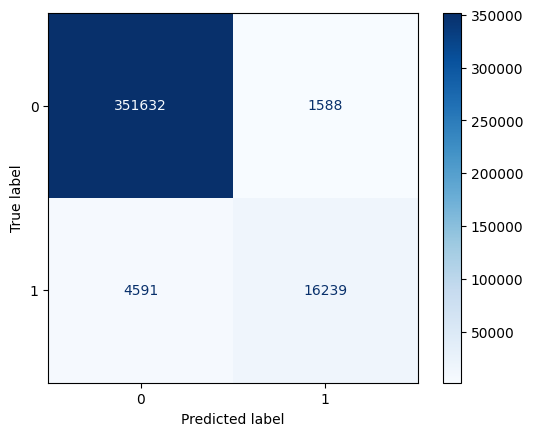

                precision    recall  f1-score   support

Normal Traffic       0.99      1.00      0.99    353220
        Attack       0.91      0.78      0.84     20830

      accuracy                           0.98    374050
     macro avg       0.95      0.89      0.92    374050
  weighted avg       0.98      0.98      0.98    374050



In [198]:
from sklearn.metrics import classification_report

cm = confusion_matrix(y_test_combined, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

# Print detailed classification report
print(classification_report(y_test_combined, y_pred, target_names=['Normal Traffic', 'Attack']))

# zoo

In [8]:
import numpy as np
import tensorflow as tf

def _bce_loss_from_logits_or_probs(y_true, y_pred):
    return tf.keras.losses.binary_crossentropy(y_true, y_pred, from_logits=False)

def _model_loss(model, x, y_true, targeted=False, y_target=None):
    """
    Returns a scalar loss tensor for one sample x with label y_true.
    For targeted attack: minimize loss to make prediction = y_target.
    For untargeted attack: maximize loss w.r.t y_true.
    """
    x_tensor = tf.convert_to_tensor(x[None, ...], dtype=tf.float32)  # shape (1,H,W,1)
    pred = model(x_tensor)

    if targeted:
        if y_target is None:
            raise ValueError("y_target must be provided for targeted=True")
        loss = _bce_loss_from_logits_or_probs(tf.convert_to_tensor([[float(y_target)]], dtype=tf.float32), pred)
        # targeted: minimize loss toward y_target
        return loss[0]
    else:
        loss = _bce_loss_from_logits_or_probs(tf.convert_to_tensor([[float(y_true)]], dtype=tf.float32), pred)
        # untargeted: maximize loss w.r.t true label -> return +loss
        return loss[0]

def _zoo_estimate_grad(model, x, y_true, coords, fd_eta, targeted=False, y_target=None):
    """
    Symmetric finite-difference gradient estimate on selected flat coords.
    Supports ANY x shape (e.g., (L,1), (L,), (H,W), (H,W,C)).
    Returns grad_est with same shape as x (np.float32).
    """
    x = x.astype(np.float32, copy=True)
    orig_shape = x.shape

    x_flat = x.reshape(-1)
    grad_flat = np.zeros_like(x_flat, dtype=np.float32)

    for idx in coords:
        orig = x_flat[idx]

        # +eta
        x_flat[idx] = np.clip(orig + fd_eta, 0.0, 1.0)
        f_plus = float(_model_loss(model, x_flat.reshape(orig_shape), y_true, targeted, y_target))

        # -eta
        x_flat[idx] = np.clip(orig - fd_eta, 0.0, 1.0)
        f_minus = float(_model_loss(model, x_flat.reshape(orig_shape), y_true, targeted, y_target))

        # restore
        x_flat[idx] = orig

        grad_flat[idx] = (f_plus - f_minus) / (2.0 * fd_eta)

    return grad_flat.reshape(orig_shape)

def zoo_attack(
    model,
    x,
    y_true,
    epsilon=0.2,
    iters=300,
    fd_eta=1e-3,
    lr=1e-2,
    coord_batch=1024,
    targeted=False,
    y_target=None,
    rng=None,
    verbose=False
):
    """
    ZOO attack for a single sample x with ANY shape (e.g., (L,1) for Conv1D).
    L_inf constraint with radius epsilon around original x.
    """
    if rng is None:
        rng = np.random.default_rng()

    x0 = x.astype(np.float32).copy()
    x_adv = x0.copy()

    flat_len = x_adv.size
    all_coords = np.arange(flat_len)

    for t in range(iters):
        coords = rng.choice(all_coords, size=min(coord_batch, flat_len), replace=False)

        g = _zoo_estimate_grad(model, x_adv, y_true, coords, fd_eta, targeted=targeted, y_target=y_target)

        # Make sparse update only on sampled coords (optional)
        if coord_batch < flat_len:
            mask = np.zeros(flat_len, dtype=np.float32)
            mask[coords] = 1.0
            g = (g.reshape(-1) * mask).reshape(x_adv.shape)

        step = -lr * np.sign(g) if targeted else lr * np.sign(g)
        x_adv = x_adv + step

        # Project to L_inf ball around x0 and clip to [0,1]
        x_adv = np.clip(x_adv, x0 - epsilon, x0 + epsilon)
        x_adv = np.clip(x_adv, 0.0, 1.0)

        if verbose and (t % max(1, iters // 10) == 0 or t == iters - 1):
            current_loss = float(_model_loss(model, x_adv, y_true, targeted, y_target))
            print(f"[ZOO] iter {t+1}/{iters} | loss={current_loss:.6f}")

    return x_adv.astype(np.float32)


from tqdm import tqdm

def zoo_attack_batch(
    model,
    X,
    y,
    epsilon=0.2,
    iters=300,
    fd_eta=1e-3,
    lr=1e-2,
    coord_batch=1024,
    targeted=False,
    y_target=None,
    rng_seed=42,
    verbose_every=0
):
    rng = np.random.default_rng(rng_seed)
    X_adv = np.empty_like(X, dtype=np.float32)
    N = X.shape[0]

    for i in tqdm(range(N), desc="ZOO attack samples"):
        ve = (verbose_every and ((i % verbose_every) == 0))
        X_adv[i] = zoo_attack(
            model,
            X[i],
            float(y[i]),
            epsilon=epsilon,
            iters=iters,
            fd_eta=fd_eta,
            lr=lr,
            coord_batch=coord_batch,
            targeted=targeted,
            y_target=(int(y_target) if y_target is not None else None),
            rng=rng,
            verbose=ve
        )
    return X_adv

In [9]:

X_test_attack_zoo = zoo_attack_batch(
    model,
    X_test_attack[:200],
    y_test_attack[:200],
    epsilon=0.2,
    iters=20,
    fd_eta=1e-3,
    lr=0.1,
    coord_batch=248,
    targeted=False,
    y_target=None,
    rng_seed=123,
    verbose_every=30
)

ZOO attack samples:   0%|          | 0/200 [00:00<?, ?it/s]

[ZOO] iter 1/20 | loss=4.111863
[ZOO] iter 3/20 | loss=26.912704
[ZOO] iter 5/20 | loss=19.078058
[ZOO] iter 7/20 | loss=18.430393
[ZOO] iter 9/20 | loss=21.260864
[ZOO] iter 11/20 | loss=26.107756
[ZOO] iter 13/20 | loss=24.570086
[ZOO] iter 15/20 | loss=26.426022
[ZOO] iter 17/20 | loss=25.200689
[ZOO] iter 19/20 | loss=21.397186
[ZOO] iter 20/20 | loss=17.918367


ZOO attack samples:  15%|█▌        | 30/200 [19:23<1:50:04, 38.85s/it]

[ZOO] iter 1/20 | loss=10.552454
[ZOO] iter 3/20 | loss=19.286161
[ZOO] iter 5/20 | loss=13.564528
[ZOO] iter 7/20 | loss=8.899692
[ZOO] iter 9/20 | loss=19.911684
[ZOO] iter 11/20 | loss=4.791114
[ZOO] iter 13/20 | loss=20.908438
[ZOO] iter 15/20 | loss=23.162357
[ZOO] iter 17/20 | loss=14.052382
[ZOO] iter 19/20 | loss=13.990586
[ZOO] iter 20/20 | loss=13.357892


ZOO attack samples:  30%|███       | 60/200 [38:39<1:31:43, 39.31s/it]

[ZOO] iter 1/20 | loss=9.113537
[ZOO] iter 3/20 | loss=21.074160
[ZOO] iter 5/20 | loss=21.780231
[ZOO] iter 7/20 | loss=18.926861
[ZOO] iter 9/20 | loss=30.043438
[ZOO] iter 11/20 | loss=29.549068
[ZOO] iter 13/20 | loss=29.549068
[ZOO] iter 15/20 | loss=29.549068
[ZOO] iter 17/20 | loss=29.549068
[ZOO] iter 19/20 | loss=29.549068
[ZOO] iter 20/20 | loss=29.350086


ZOO attack samples:  45%|████▌     | 90/200 [57:48<1:09:52, 38.12s/it]

[ZOO] iter 1/20 | loss=3.677195
[ZOO] iter 3/20 | loss=17.832933
[ZOO] iter 5/20 | loss=16.363863
[ZOO] iter 7/20 | loss=31.058676
[ZOO] iter 9/20 | loss=30.895399
[ZOO] iter 11/20 | loss=24.928223
[ZOO] iter 13/20 | loss=39.126469
[ZOO] iter 15/20 | loss=46.810139
[ZOO] iter 17/20 | loss=6.543803
[ZOO] iter 19/20 | loss=35.335339
[ZOO] iter 20/20 | loss=32.349724


ZOO attack samples:  60%|██████    | 120/200 [1:17:10<51:11, 38.39s/it]  

[ZOO] iter 1/20 | loss=16.230371
[ZOO] iter 3/20 | loss=27.379717
[ZOO] iter 5/20 | loss=27.613804
[ZOO] iter 7/20 | loss=22.822603
[ZOO] iter 9/20 | loss=9.766754
[ZOO] iter 11/20 | loss=19.441326
[ZOO] iter 13/20 | loss=22.632179
[ZOO] iter 15/20 | loss=15.962447
[ZOO] iter 17/20 | loss=17.560568
[ZOO] iter 19/20 | loss=13.223332
[ZOO] iter 20/20 | loss=7.782861


ZOO attack samples:  75%|███████▌  | 150/200 [1:36:36<32:19, 38.79s/it]

[ZOO] iter 1/20 | loss=9.542930
[ZOO] iter 3/20 | loss=22.070263
[ZOO] iter 5/20 | loss=24.044172
[ZOO] iter 7/20 | loss=19.932299
[ZOO] iter 9/20 | loss=21.591679
[ZOO] iter 11/20 | loss=17.645723
[ZOO] iter 13/20 | loss=26.493845
[ZOO] iter 15/20 | loss=15.009027
[ZOO] iter 17/20 | loss=25.360155
[ZOO] iter 19/20 | loss=20.093132
[ZOO] iter 20/20 | loss=17.873417


ZOO attack samples:  90%|█████████ | 180/200 [1:56:06<12:56, 38.83s/it]

[ZOO] iter 1/20 | loss=20.699154
[ZOO] iter 3/20 | loss=20.623680
[ZOO] iter 5/20 | loss=19.391865
[ZOO] iter 7/20 | loss=17.401312
[ZOO] iter 9/20 | loss=17.155952
[ZOO] iter 11/20 | loss=12.373065
[ZOO] iter 13/20 | loss=11.979078
[ZOO] iter 15/20 | loss=12.364174
[ZOO] iter 17/20 | loss=14.632209
[ZOO] iter 19/20 | loss=16.072535
[ZOO] iter 20/20 | loss=15.634804


ZOO attack samples: 100%|██████████| 200/200 [2:09:06<00:00, 38.73s/it]


In [11]:
# ---- Rebuild the (scaled) test set and labels ----
X_test_combined = np.vstack((X_test_normal, X_test_attack_zoo))
y_test_combined = np.hstack((y_test_normal, y_test_attack[:200]))

from sklearn.utils import shuffle
X_test_adv_final, y_test_adv_final = shuffle(
    X_test_combined, y_test_combined, random_state=1
)

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Get predictions
y_pred = model.predict(X_test_adv_final)
y_pred = (y_pred > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test_adv_final, y_pred)
precision = precision_score(y_test_adv_final, y_pred, average='weighted')
recall = recall_score(y_test_adv_final, y_pred, average='weighted')

# Print results
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Precision: {precision * 100:.2f}%")
print(f"Test Recall: {recall * 100:.2f}%")


11045/11045 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step
Test Accuracy: 99.53%
Test Precision: 99.89%
Test Recall: 99.53%


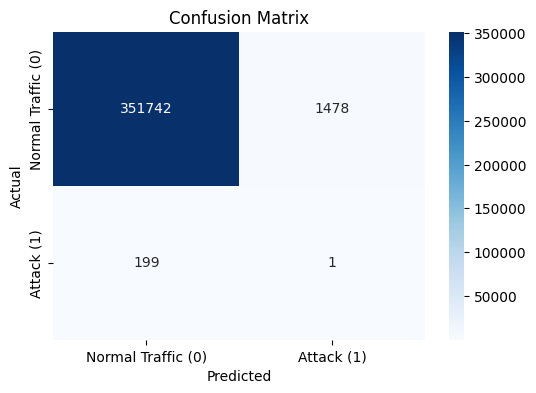

                precision    recall  f1-score   support

Normal Traffic       1.00      1.00      1.00    353220
        Attack       0.00      0.01      0.00       200

      accuracy                           1.00    353420
     macro avg       0.50      0.50      0.50    353420
  weighted avg       1.00      1.00      1.00    353420



In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Compute confusion matrix
cm = confusion_matrix(y_test_adv_final, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal Traffic (0)', 'Attack (1)'], yticklabels=['Normal Traffic (0)', 'Attack (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print detailed classification report
print(classification_report(y_test_adv_final, y_pred, target_names=['Normal Traffic', 'Attack']))


In [21]:
len(packets_attack_test)

20830

In [22]:
X_test_attack_zoo.shape

(200, 100, 1)

In [25]:
save_fgsm_modified_packets(packets_attack_test[:200], x_adv_uint8, r"C:\Users\ulami\Desktop\datasety\UNSW-NB15-pcap\unsw_zoo_full_modified.pcap")

C:\Users\ulami\AppData\Local\Temp\ipykernel_9800\1371682187.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pkt[IP].ttl = int(fgsm_bytes[24])
C:\Users\ulami\AppData\Local\Temp\ipykernel_9800\1371682187.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ns_flag = int(fgsm_bytes[48]) & 1
C:\Users\ulami\AppData\Local\Temp\ipykernel_9800\1371682187.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  win_size = int(fgsm_bytes[50]) << 8 | int(fgsm_bytes[51])


✅ Saved 200 FGSM-modified packets to: C:\Users\ulami\Desktop\datasety\UNSW-NB15-pcap\unsw_zoo_full_modified.pcap
